<h1 align="center">Medium Archive  Analysis (Data Analysis Phase)</h1>

<br>
In this notebook I will create an extensive exploratory data analysis with the data that results from our data-cleaning notebook, "Data_Cleaning_Prototype". This notebook is meant to be the "answer everything" notebook, where I answer every question I could possibly think about the dataset. As a result, this notebook is very long.

I will break up this notebook into smaller notebooks intended for different audiences. My current idea is:
- General EDA - A topical overview of the dataset.
- Author metric notebook- Where I analyze the performance of authors and create a cutoff for the top 1% of authors.
- Publication analysis notebook - Here I rank Medium's publications by claps, total articles released, and total authors.
- Top 1k Analysis - A look at the top 100 most clapped articles in our dataset. What makes them succesful?

## Where the data came from.

I pulled this data from Medium's archive pages. Each archive page is associated to a story-tag and is a <b>collection of Medium timeline cards organized by date.</b>
<br>

<h3 align="center"> Image of the "<a href="https://medium.com/tag/data-science/archive">data-science</a>" Archive</h3>

### How the data was scraped
The data was pulled from from  36 popular Medium story-tag archives. Each archive was <b>scraped for each day between Aug 1, 2017 and Aug 1, 2018.</b>

These dates were chosen because:
1. Medium's clap metric was introduced in August 2017, and older posts might not be relevant. 
2. The popularity of Medium may have grown, so older posts may not generalize to the preformance of posts today. 
3. The end date was chosen so that newer posts (September) were not included, as they have not had time to mature and accumulate claps.

### The 36 Tags Scraped
['ai', 'artificial-intelligence',
 'blogging', 'business',
 'data-science', 'design',
 'education', 'entrepreneurship',
 'health', 'humor',
 'inspiration', 'javascript',
 'leadership', 'life',
 'life-lessons', 'love',
 'machine-learning', 'marketing',
 'motivation', 'personal-development',
 'poetry', 'politics',
 'productivity', 'programming',
 'python', 'racism',
 'science', 'self-improvement',
 'software-engineering', 'startup',
 'tech', 'technology',
 'travel', 'web-design',
 'web-development', 'writing']

 


## Structure of the data
- Title -title of article on timeline card
- Subtitle  -subtitle of article on timeline card
- Image (yes/no)-whether the article has a preview image on its timeline card
- Author -writer of the story
- Publication - the name of the publication the article may have been posted in
- Year - Month - Day-date the article was published
- Tag (One-Hot-Encoded)
- Reading Time- Time to read the article
- Claps-Number of claps the article received
- Comment (yes/no)-whether the entry is a comment on another article
- Story Url-link to story
- Author URL-link to Author's Medium homepage

<br>
<h3 align="center"> Example of Data Scraped from a Timeline Card</h3>

 
## Purpose of the Data
 1. To <b>create a performance metric for Medium's authors</b>, so they can compare their work to the rest of Medium.
 2. To <b>compare the performance of authors and publications</b> on Medium. 
 

## Overview of Data Cleaning

<b>Before cleaning: 993k entries</b>

- Removed comment entries (-63k)
- Removed articles reposted by author on different date (-21k)
- Combined multi-tagged articles, that appeared on different archive pages. (-189k)

<b>After cleaning: 720k entries</b>

<hr>
<h1 align="center">Loading the Clean Data</h1>



In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#myscreen dpi for fine-tuning figure sizes for Medium
dpi=144

medium = pd.read_csv("Medium_Clean.csv")
medium = medium.drop("Unnamed: 0", axis=1)

medium.head(3)

,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,...,Tag_science,Tag_self-improvement,Tag_software-engineering,Tag_startup,Tag_tech,Tag_technology,Tag_travel,Tag_web-design,Tag_web-development,Tag_writing
0,Online Animation: Mixamo vs Norah AI,Online animations tools provide game designers...,1,Emma Laurent,NaN,2017,8,1,5,12.0,...,0,0,0,0,0,0,0,0,0,0
1,Uml inteligence pro lidi,Ped vce jak mscem jsem ml monost pednet na min...,1,Josef Holy,Paraleln Hyperbola,2017,8,1,12,5.0,...,0,0,0,0,0,0,0,0,0,0
2,"Image mining on the blockchain, a new horizon",Blockchain is great at decentralizing control ...,1,George Alex Popescu,NaN,2017,8,1,4,5.0,...,0,0,0,0,0,0,0,0,0,0


<hr>
<h1 align="center">Summarizing the Dataset</h1>
## 720k articles, 230k authors, and 30k publications

In [2]:
print("Number of Articles: ", medium.shape[0])
print("Number of Authors: ", medium.Author.value_counts().shape[0])
print("Number of Publications: ", medium.Publication.value_counts().shape[0])
print("Number of Tags: ", medium.columns[12:].shape[0])

Number of Articles:  720533
Number of Authors:  230548
Number of Publications:  30473
Number of Tags:  36


## Range of Claps Received by a Single Article (0 - 215K claps)

In [3]:
print("Minimum # CLaps by an Article: ", int(medium.Claps.min()), )
print("Maximum # Claps by an Article: ", int(medium.Claps.max()))

Minimum # CLaps by an Article:  0
Maximum # Claps by an Article:  215000


<hr>
<h1 align="center">Analyzing 700k Medium Articles</h1>
<br>
Since we scaped timeline cards, each entry in our dataset represents an article published in one of the 36 scraped tags. Some information that I want to look at: 
- When were these articles posted?
- How many claps do most articles receive?
    - What is the 99th percentile of claps-received? <b>(Author performance metric.)</b>
- How long are most Medium articles?

## When were these articles posted?
Note that we can't say that the articles in our dataset represent all articles posted in that one year period. There may have been 403 errors while scraping that prevented some articles from being scraped.

Instead, the date data is combined in the below graph, which represents the number of articles we succesfully scraped for each month in our scraping period (8/17-8/18). <b>We scraped around 60k articles each month from August 1st, 2017 to August 1st 2018.</b>

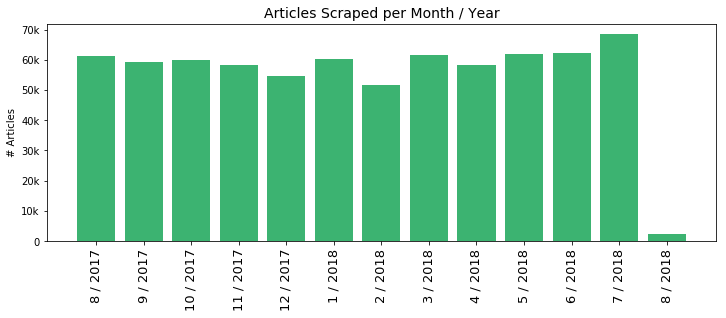

In [4]:
years = [2017,2018]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
ym_counts = []
bar_x = []
for year in years:
    for month in months:
        ym_counts.append(medium[(medium.Year==year)&(medium.Month==month)].shape[0])
        bar_x.append(str(month)+" / "+str(year))

ym_counts = ym_counts[7:-4]     
bar_x = bar_x[7:-4]

plt.figure(figsize=(12,4))
plt.bar(bar_x, ym_counts, color = "mediumseagreen")
plt.title("Articles Scraped per Month / Year", fontsize=14)
plt.ylabel("# Articles")
plt.yticks([0,10000,20000,30000,40000,50000,60000,70000],
           ["0", "10k","20k","30k","40k","50k", "60k", "70k"])
plt.xticks(rotation=90, fontsize=13)
plt.show()

## How many claps do Medium articles receive?
This section is where our data really shines. Since we collected 700k unique articles from Medium, we can get a good estimate of how many claps Medium posts tend to get. We can use this estimate to make a reasonable metric for a succesful article. <b>In this analysis, we will say that an exceptional article receives the 99th percentile of claps.</b> As exceptional tends to be a comparative term, this measure seems reasonable to me.

### Most articles receive close to zero claps.
Here we find that most articles receive very few claps. (Less than ten.) <b>61% of our articles receive less than 10 claps.</b> Notice how different the sizes of the bins are. Clearly the distribution of claps is HIGHLY skewed towards zero.

In [5]:
def plot_double(x, height, leftlabel, rightlabel, xlabel=None, ylabel=None, ylocs=None, yticks=None,ylim=None, title = "61% of Articles Receive Less Than Ten Claps"):
    plt.figure(figsize=(7,7))
    plt.bar(x, height, color="mediumseagreen")
    plt.text(0-.1,height[0]+(max(height)*0.05), str(round(100*height[0]/sum(height),1))+"%", fontsize=14)
    plt.text(1-.1,height[1]+(max(height)*0.05), str(round((100*height[1]/sum(height)),1))+"%", fontsize=14)

    plt.title(title, fontsize=14)
    plt.xticks([0,1], [leftlabel, rightlabel], fontsize=13)
    if xlabel:
        plt.xlabel(xlabel,fontsize=13)
    if ylabel:
        plt.ylabel(ylabel,fontsize=13)
    if ylocs:
        plt.yticks(ylocs, yticks)
    if ylim:
        plt.ylim(0,ylim)

    plt.show()


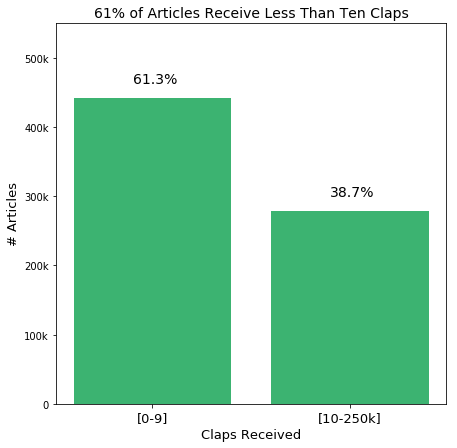

In [6]:
all_articles = medium.shape[0]
under10 = medium[medium.Claps<10].shape[0]
over10 = all_articles-under10

x = [0, 1]
height= [under10, over10]

ylocs = [0,100000,200000,300000,400000,500000]
yticks = ["0","100k", "200k", "300k", "400k", "500k"]

plot_double(x, height,
            "[0-9]",
            "[10-250k]",
            xlabel="Claps Received",
            ylabel="# Articles",
            ylocs=ylocs,
            yticks=yticks,
            ylim = 550000,
            title="61% of Articles Receive Less Than Ten Claps")

As the default number of claps is zero, a majority of posts will only receive a few claps. There are a lot of high performing articles though. The highest claps achieved by a single <a href="https://hackernoon.com/im-harvesting-credit-card-numbers-and-passwords-from-your-site-here-s-how-9a8cb347c5b5">article</a> is 215k.


### Exceptional articles receive two thousand claps.

To get a better understanding of how many artcles are exceptional (99th percentile), we need to plot a smooth estimation of the distribution of claps in our data. We see below the frequency of articles who receive a certain number of claps.

A vast majority of articles receive very few claps, However, there are quite a few articles on Medium who are above the 99th percentile of claps. <b>Note that the range of the claps (0-215k claps) extends far beyond the range of the plot.</b> Also notice that the 99th percentile of claps is included in the visual. Falling at 2000 claps.<b>Therefore, the cutoff for an exceptional article on Medium is 2000 claps.</b>

In [7]:
def plot_frequency(kde_data, clip=[0,10000],bw='scott',yvariable = "Article", xvariable = "claps", title = "Exceptional",shorten=False, claplocs=[], kclaps=[]):
    plt.figure(figsize=(12,6))
    sns.kdeplot(kde_data,bw=bw, shade=True, legend=False, clip=clip, color = "mediumseagreen" )
    ninenine = kde_data.quantile(q=0.99)
    plt.axvline(x=ninenine, color="mediumseagreen")
    plt.axvspan(ninenine, clip[1], alpha=0.1, color='lightgreen')
    plt.text(ninenine+(clip[1]-ninenine)*0.075,
                       plt.yticks()[0][-1]/2.5,
                       "Top 1% = "+str(int(ninenine))+ " "+xvariable+".",
                       fontsize=14)

    plt.title(title, fontsize=15)
    plt.ylabel("Frequency of "+yvariable.title(), fontsize=13)
    plt.yticks([])

    plt.xlabel(xvariable.title(), fontsize=13)
    if shorten:
        plt.xticks(claplocs,kclaps, fontsize=12)
    plt.xlim(1,clip[1])

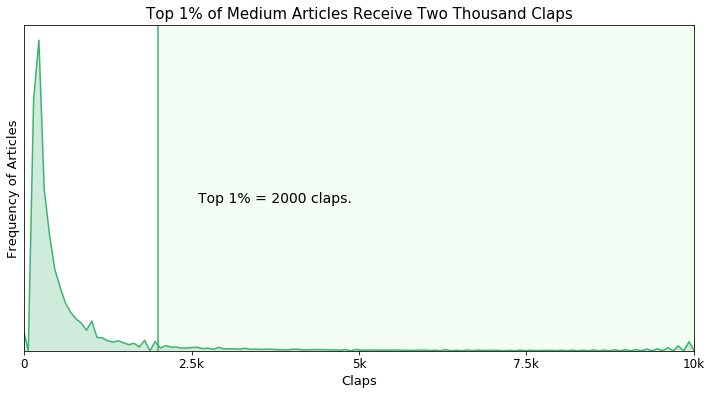

In [8]:
kclaps = ["0","2.5k", "5k", "7.5k", "10k", "12.5k", "15k", "17.5k", "20k"]
claplocs = [0,2500, 5000,7500, 10000,12500,15000,17500,20000]
#KDE plot, shade below curve, clip arg includes values of 0 to 20000

plot_frequency(medium.Claps,
              clip=[0,10000],
               yvariable="Articles",
               xvariable="claps",
              title="Top 1% of Medium Articles Receive Two Thousand Claps",
               shorten=True,
              claplocs=claplocs,
              kclaps=kclaps)


plt.show()

## How long are Medium articles?

<b>Most Medium articles are 2-3 minutes in length.</b> This suprised me as most of the data science articles I read are around 7-8 minutes in length.

My first thought was maybe a certain tag I scraped has exceptionally short articles, skewing the population reading time. However, <b>after analyzing inividual tags I found that a majority of the tags I scraped contain articles of comparable length to what we find here.</b>

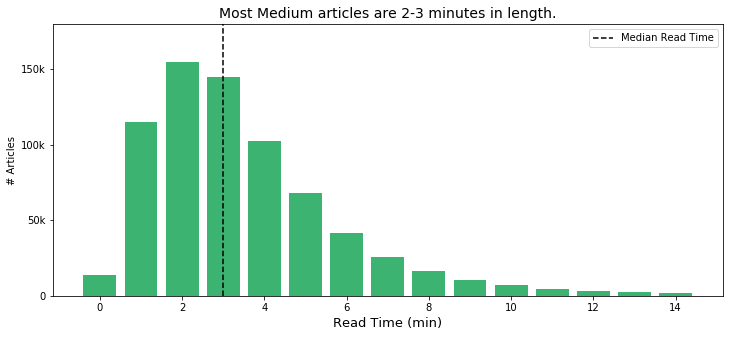

In [9]:
avs=[]
medians=[]
total_cs = []
readts=[]
entries = []
for x in range(15):
    medians.append(medium[medium.Reading_Time==x].Claps.quantile(q=0.5))
    readts.append(x)
    entries.append(medium[medium.Reading_Time==x].shape[0])
    total_cs.append(medium[medium.Reading_Time==x].Claps.sum())

plt.figure(figsize=(12,5))
plt.bar(readts,entries, color="mediumseagreen")
plt.vlines(medium.Reading_Time.median(),0,190000,
           color="black",
           linestyle="dashed",
           label="Median Read Time")
plt.title("Most Medium articles are 2-3 minutes in length.", fontsize=14)
plt.yticks([0,50000,100000,150000], ["0","50k", "100k", "150k"])
plt.ylim(0,180000)
plt.ylabel("# Articles")
plt.xlabel("Read Time (min)", fontsize=13)
plt.legend()

plt.show()

We will now look at the subpopulations of our dataset. Tags are Medium's way of grouping topics of writing. This way Medium members that are interested in coding and Javascript will have stories related to their interest appear in their home-feed.

Since most people only follow a few tags that they are interested in, articles in different tags have different reader-bases. This raises the question, <b>"Do articles in different Tags differ in nature (and success) from stories in other tags?"</b>

In the next section we seek to answer this question futher.

<hr>
<h1 align="center">Analyzing Medium Tags</h1>

In this section I look at each tag-subpopulations of my data set. Questions we want answered:
- How many articles did we scrape from each tag?
- Does any tag receive more applause?
    - Does the cutoff for an exceptional article vary for each tag? <b>(Author performance metric)</b>
- Are any tag's articles longer than average? 

## How many articles did we scrape from each tag?

On average, <b>I was able to scrape around 25k from most tag-archives for the 2017-2018 year.</b> I contemplated removing the tags with fewer articles but decided against it. I thought it better to leave the data how I received it, than cherry pick more popular tags.

In [10]:
def sort_helper(names,numbers):
    #change to array
    numbers = np.array(numbers)
    names = np.array(names)    
    #sort tag article-counts for aesthetics    
    sort_idx = list(reversed(np.argsort(numbers)))
    numbers = numbers[sort_idx]
    names = names[sort_idx]
    return names, numbers

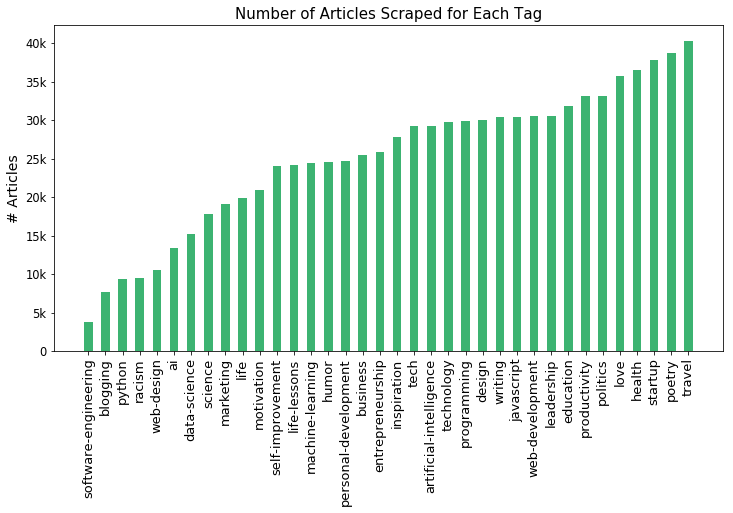

In [11]:
tag_counts=[]
tag_names=[]
for x in medium.columns[12:].values:
    tag_names.append(x[4:])
    tag_counts.append(medium[x].sum())

tag_names, tag_counts = sort_helper(tag_names, tag_counts)
tag_names = np.flip(tag_names,axis=0)
tag_counts = np.flip(tag_counts,axis=0)


plt.figure(figsize=(12,6))
plt.bar(tag_names ,tag_counts,width=0.5, color="mediumseagreen")
plt.title("Number of Articles Scraped for Each Tag", fontsize=15)
plt.ylabel("# Articles", fontsize=14)
plt.yticks(fontsize=11.5)
plt.xticks(rotation=90, fontsize=13)
plt.yticks([0,5000,10000,15000,20000,25000,30000,35000,40000], ["0", "5k", "10k", "15k", "20k", "25k", "30k", "35k", "40k"])
#plt.axhline(y=tag_counts.mean(), color="midnightblue", linestyle="dashed", label="Average Articles per Tag")
#plt.legend(prop={'size': 12})

plt.show()

## Does any tag receive more applause?

<b>Each tag has a similar distribution of claps-received.</b> Here we see that most all tags follow the trend of having most articles receive very few claps. However, there are a few tags that have exceptionally high frequency of low-clap articles. One such tag is the highest curve to the left, in pink, represents the poetry tag.



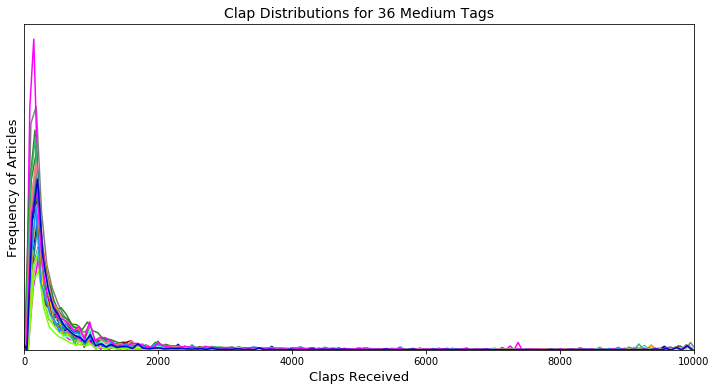

In [12]:
tags = medium.columns[12:]
colors = ["mediumseagreen","darkcyan", "lightcoral", "aquamarine", "chartreuse", "dodgerblue","magenta", "mediumblue","teal",
          "grey","orange", "forestgreen","darkred","gold","steelblue","beige", "firebrick","chocolate",
          "green","red","darkslateblue","thistle","c", "hotpink"]
colorcount=0

plt.figure(figsize=(12,6))
ax=plt.subplot()
colorcount=0
for tag in tags:
    if colorcount==14:
        colorcount=0
    Color = colors[colorcount]  
    sns.kdeplot(medium[medium[tag]>0].
                Claps,
                color=Color,
                clip=[0,10000],
                ax=ax,
                legend=False)
    colorcount+=1
    
plt.title("Clap Distributions for 36 Medium Tags", fontsize=14)
plt.xlabel("Claps Received", fontsize=13)
plt.yticks([])
plt.ylabel("Frequency of Articles", fontsize=13)
plt.xlim(0,10000)
plt.show()

### The 99th percentile of claps-received varies for each tag.

Here we see that <b>there is a significant spread of the top performing articles for each tag.</b> If we were to create a metric out of the 99th percentile, we would have to consider that the tag an author is writing in may have higher standards than other tags. <b>This means that it will be harder to write an exceptional story in some tags, and easier in others.</b>


For example, an article in the "travel" tag only needs 544 claps to be exceptional, while an artile written in "self-improvement" needs 6661 claps. Thats 12 times as many claps...

This doesn't mean that some author's should choose to write in tags that are easier to reach the top 1%, in fact it may be the opposite. Take for example the "travel" tag. We know its 99th percentile falls at 544 claps. This means that nearly every article with the travel-tag underperformed when compared to the population metric ot two thousand claps.

<b>Thought experiment: the "travel" tag has the most articles scraped, but the lowest 99th percentile. What does that mean?</b>

In [13]:
#a list of ninety ninth percentiles for all tags.
tags_ninenine=[]
for tag in tags:
    ninenine = medium[medium[tag]>0].Claps.quantile(q=0.99)
    tags_ninenine.append(ninenine)

tags_sort, tags_ninenine = sort_helper(tags,tags_ninenine)
tags_sort = np.flip(tags_sort, axis=0)
tags_ninenine = np.flip(tags_ninenine, axis=0)


temp=[]
for idx in range(len(tags_sort)):
    temp.append(tags_sort[idx][4:])
tags_sort = temp

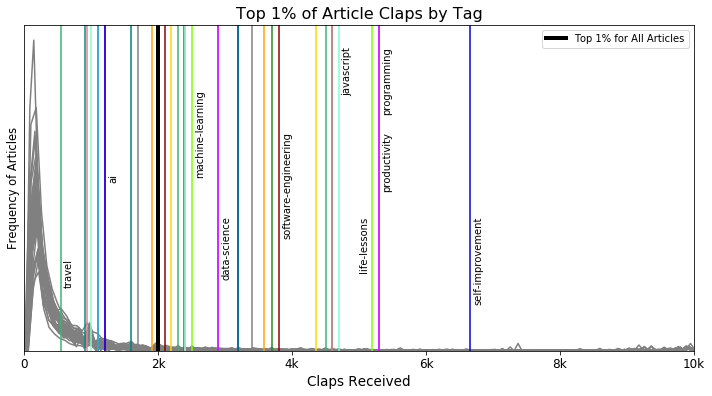

In [14]:
plt.figure(figsize=(12,6))
ax=plt.subplot()

#plotting the Clap Densities
for tag in tags:
    sns.kdeplot(medium[medium[tag]>0].Claps,
                color="grey",
                clip=[0,10000],
                label="",
                ax=ax,
                legend=False)
    
#plot the 99th percentiles
colorcount=0
vertical = 0.0004   
for idx in range(len(tags_sort)):       
    if colorcount==14:
        colorcount=0
    if vertical>0.0014:
        vertical = 0.0006
    Color = colors[colorcount]  
    tag = tags_sort[idx]
    plt.axvline(x=tags_ninenine[idx], color=Color)
    colorcount+=1
    if idx == 32:
        plt.text(tags_ninenine[idx]-200,vertical, tag, rotation=90)
        vertical+=0.0004
        continue
    if idx not in [0,7,18,20,26,31,32,33,34,35,36]:
        continue
    plt.text(tags_ninenine[idx]+50,vertical, tag, rotation=90)
    vertical+=0.0004

plt.axvline(x=2000, color="black",lw=4, label="Top 1% for All Articles")

plt.title("Top 1% of Article Claps by Tag", fontsize=16)
plt.xlabel("Claps Received", fontsize=13.5)
plt.yticks([])
plt.ylabel("Frequency of Articles", fontsize=11.5)
plt.xticks([0,2000,4000,6000,8000,10000], ["0","2k","4k","6k", "8k", "10k"], fontsize=12)
plt.xlim(0,10000)
plt.legend()
plt.show()

So perhaps if an author wanted to measure the performance of their article, they could first look at the performance compared to all articles on Medium (Top 1% ~2000 clap), then they could measure against other articles with similar subject matter (similar tags). 


### Number of claps exceptional articles receive for each tag. 

If you were to measure your article's performance, <b>you might compare it to whichever 99th percentile is highest. That may be the population metric of two thousand claps, or the 99th percentile of the tag you write in (~2900 claps data-science for me.)</b>


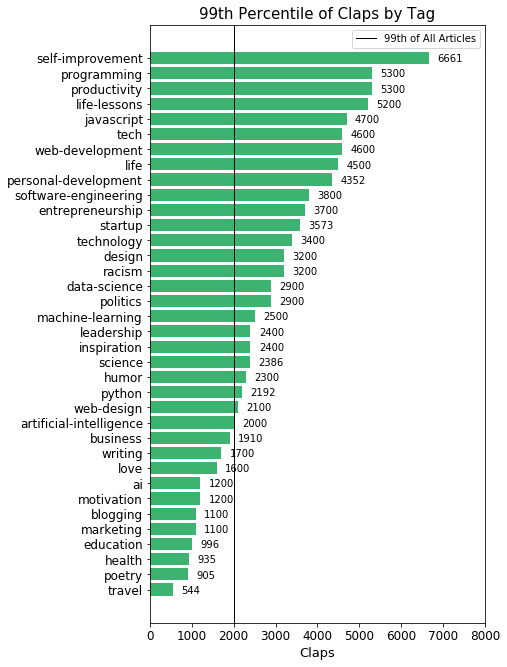

In [15]:
plt.figure(figsize=(6,11))
plt.barh(tags_sort,tags_ninenine, color="mediumseagreen")
plt.axvline(medium.Claps.quantile(0.99), color="black",lw=1,label="99th of All Articles")

for idx in range(len(tags_ninenine)):
    plt.text(tags_ninenine[idx]+200, idx-.25, str(int(tags_ninenine[idx])))

plt.title("99th Percentile of Claps by Tag", fontsize=15)
plt.legend()
plt.xlabel("Claps", fontsize=13)
plt.xticks(fontsize=12)
plt.xlim(0,8000)
plt.yticks(fontsize=12)
plt.show()

## Do some tags tend to have longer stories than others?

Below we see KDE plots estimating the distribution of reading times for each Medium tag. <b>Most tags have articles that are similar in length, except for poetry which is exceptionally short.</b> Poetry is the pink line, which is left shifted since (as we will see) poetry articles tend to be shorter.

In [16]:
tags = medium.columns[12:]
rt_medians=[]
readts=[]
rt_counts = []
rts_by_tag={}

for tag in tags:
    tag_df = medium[medium[tag]>0]
    rt_medians.append(tag_df.Reading_Time.median())
    for mins in range(32):
        readts.append(mins)
        rt_counts.append(tag_df[tag_df.Reading_Time==mins].shape[0])
    temp = [readts,rt_counts]
    rts_by_tag[tag]=temp
    readts=[]
    rt_counts = []
    temp=[]    

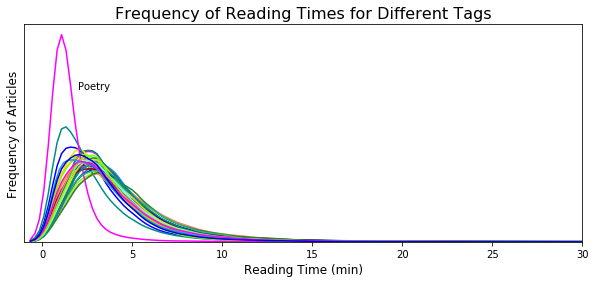

In [17]:
colors = ["mediumseagreen","darkcyan", "lightcoral", "aquamarine", "chartreuse", "dodgerblue","magenta", "mediumblue","teal",
          "blue","orange", "forestgreen","darkred","gold","steelblue","beige", "firebrick","chocolate",
          "green","red","darkslateblue","thistle","c", "hotpink"]
colorcount=0
plt.figure(figsize=(10,4))
ax=plt.subplot()
colorcount=0
for tag in tags:
    if colorcount==14:
        colorcount=0
    Color = colors[colorcount]
    sns.kdeplot(medium[medium[tag]>0].Reading_Time,
                color=Color,
                bw=.55,
                label=tag[4:],
                clip=[0,30],
                ax=ax,
                legend=False)
    colorcount+=1
    
plt.title("Frequency of Reading Times for Different Tags", fontsize=16)
plt.xlabel("Reading Time (min)", fontsize=12)
plt.text(2, 0.4, "Poetry")
plt.yticks([])
plt.ylabel("Frequency of Articles", fontsize=12)
plt.xlim(-1,30)
plt.show()

### The longest and shortest tags.

This plot displays the median read time of each tag. Note that the median of each tag describes the number of minutes that most articles in that tag fall under. <b>Here we see that most tags are consistent to having a median read time of 3 minutes.</b> Poetry however, has an exceptionally short read time compared to the other tags.

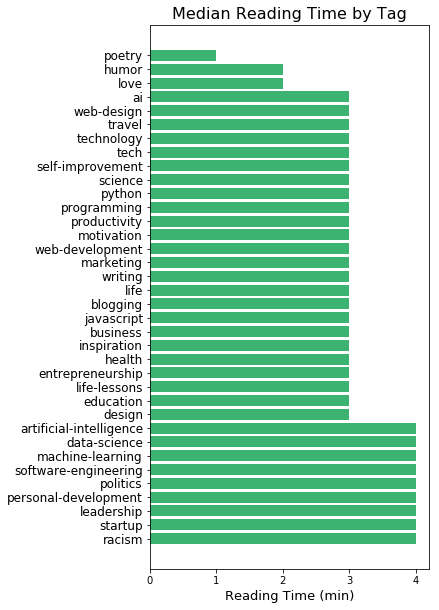

In [18]:
#sort
tags_sort, rt_medians_sort = sort_helper(tags, rt_medians)    

for x in range(len(tags_sort)):
    tags_sort[x]=tags_sort[x][4:]
    
plt.figure(figsize=(5,10))
plt.barh(tags_sort, rt_medians_sort, color="mediumseagreen")
plt.title("Median Reading Time by Tag", fontsize=16)
plt.xlabel("Reading Time (min)", fontsize=13)
plt.xticks([0,1,2,3,4],)
plt.yticks(fontsize=12)
plt.show()

The quality of articles in each tag depends on the authors that create content for their reader base. In the next section we look at how we can compare authors to each other, and better understand the creators of Medium.

<hr>
<h1 align="center">Analyzing Medium Authors</h1>

In this section we will seek to look at Medium's community of authors. Specifically:
- What percent of authors have been published in a publication?
- How many articles do most authors write?
    - Who are the most prolific writers?

## What percent of authors have been published in a publication?
Becoming a writer in a publication is a significant step towards becoming a high-performing Medium writer. By writing for a publication, the readership of your articles drastically increases, but just how many authors take this step? <b>In this dataset, we find that a quarter of all authors have written for a Medium publication.</b>

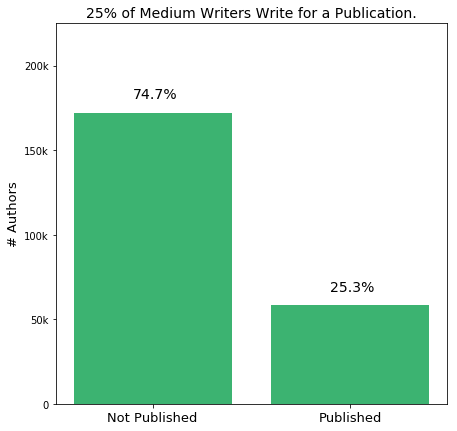

In [19]:
All_Authors = medium.Author.value_counts().shape[0] 
Published_Authors = medium[pd.notnull(medium.Publication)].Author.value_counts().shape[0] 
Not_Published_Authors = All_Authors-Published_Authors

x = [0, 1]
height= [Not_Published_Authors, Published_Authors]

ylocs = [0,50000,100000,150000,200000]
yticks = ["0","50k","100k","150k", "200k"]

plot_double(x, height,
            "Not Published",
            "Published",
            xlabel=None,
            ylabel="# Authors",
            ylocs=ylocs,
            yticks=yticks,
            ylim=225000,
            title="25% of Medium Writers Write for a Publication.")

## How many articles did most authors write?


 I shocking insight from our data, <b> 57% of Medium authors only wrote one story.</b> These writers have only written one article in the period of 8/2017-8/2018. 

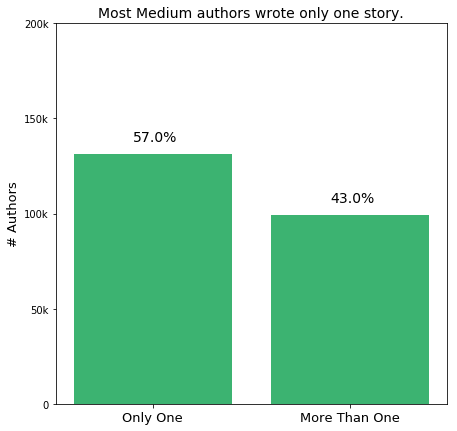

In [20]:
author_counts = medium.Author.value_counts()
single_posters = author_counts[author_counts<2].shape[0]
all_authors = author_counts.shape[0]
more_posters = all_authors-single_posters

x = [0, 1]
height= [single_posters, more_posters]

ylocs = [0,50000,100000,150000,200000]
yticks = ["0","50k","100k","150k", "200k"]

plot_double(x, height,
            "Only One",
            "More Than One",
            xlabel=None,
            ylabel="# Authors",
            ylocs=ylocs,
            yticks=yticks,
            ylim=200000,
            title="Most Medium authors wrote only one story.")

So most authors wrote only one article in this one year period. But how many articles do the most frequently published authors write? <b>Prolific writers (top 1% most published) have written more than 29 articles in the 8/2017-8/2018 period.</b>

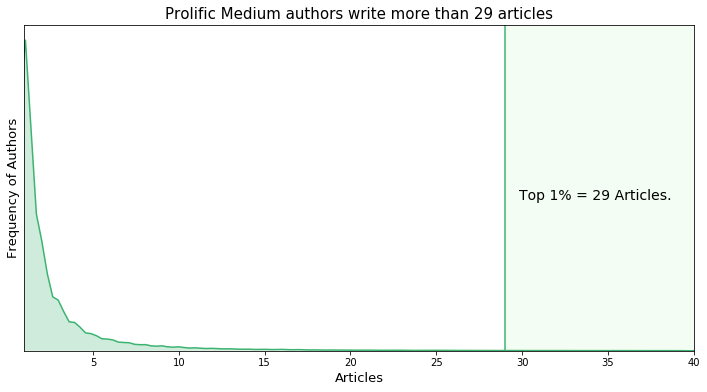

In [21]:
plot_frequency(medium.Author.value_counts(),
              clip=[0,40],
               bw=0.4,
              yvariable = "Authors",
               xvariable="Articles",
              title="Prolific Medium authors write more than 29 articles",
              shorten=False)
plt.show()

### Top 10 Most Prolific Authors
Here I have to start at the 2nd top ranked author as the first ranked author is a combination of all chinese writing authors (authors who type with chinese symbols.). My scraper only saved unicode symbols, so chinese characters were saved as a space. Instead of being counted seperately, Chinese authors are counted together.

In [22]:
print("Top 10 Most Published Authors")
print()
print("# Articles     Author                 URL")
count = 0
for auth in medium.Author.value_counts()[1:11].index:
    number = medium.Author.value_counts()[1:11][count]
    count+=1
    link = medium[medium.Author==auth].Author_url.values[0]
    link = link.split("?")[0]
    print(number,"     ",auth, "    ",link)

Top 10 Most Published Authors

# Articles     Author                 URL
1052       Scott Myers      https://gointothestory.blcklst.com/@scottdistillery
837       WooCommerce      https://medium.com/@WooCommerce
828       Programming Buddy Club      https://medium.com/@programmingbuddyclub
790       Yitzi Weiner      https://medium.com/@rabbiweiner
784       Rosemary Nonny Knight      https://medium.com/@rosemarynknight
550       Devin C. Hughes      https://medium.com/@DevinCHughes
544       Deborah Kristina      https://medium.com/@deborahkristina
526       Edward FT Charfauros      https://medium.com/@EdCharfauros
521       CSS3 Recipes      https://medium.com/@Css3Recipes
478       sumeet jannu      https://medium.com/@sumeetjannu


<hr>
<h1 align="center">Measuring Author Performance</h1>

In this section we will flesh out a metric to measure author performance. The metrics we will  look at?
- Average claps per Article.
- Creation of an 99th percentile article.
    - How many exceptional articles do top authors write?
    

## Total Claps Received

In [51]:
temp = medium.copy()
#creates a row that we will sum to get total articles by each author
temp["count"] = 1
auths_arts = temp.groupby("Author").sum()
total_claps = auths_arts["Claps"]
total_claps = np.flip(total_claps.sort_values(ascending=False)[:10], axis=0)

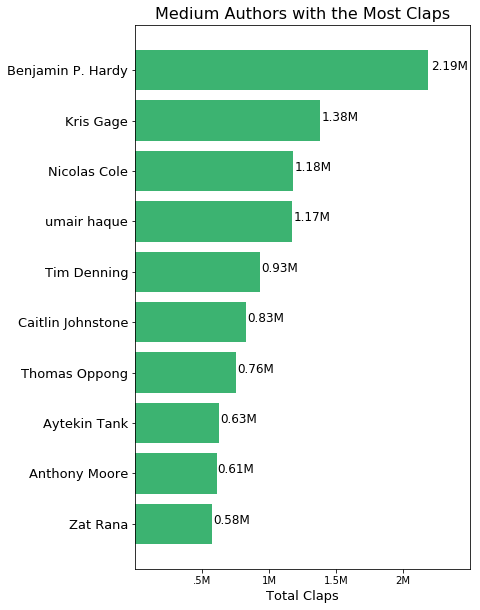

In [60]:
plt.figure(figsize=(6,10))
plt.barh(total_claps.index, total_claps, color="mediumseagreen")

for idx in range(10):
    value = total_claps[idx]
    plt.text(value *1.01, idx, str(round(value/1000000,2))+ "M", fontsize=12)

plt.title("Medium Authors with the Most Claps", fontsize=16)
plt.xlim(0,2500000)
plt.xlabel("Total Claps",fontsize=13)
plt.xticks([500000,1000000,1500000,2000000],[".5M","1M", "1.5M", "2M"])
plt.yticks(fontsize=13)
plt.show()

## Average claps per article.

Is average claps per article a good metric to measure authors by? I say yes, as <b>it favors authors who consistently write high-performing articles. The downside? It inflates authors who are "one-hit-wonders".</b> These authors write one post that skyrockets in claps, then never write again.


That being said, what is the top 1% claps/article? <b>The top 1% of Medium authors average 1200 claps per article.</b>

In [25]:
auths_arts["CA_Ratio"] = auths_arts['Claps']/auths_arts["count"]
CA = auths_arts.sort_values("CA_Ratio", ascending=False)[["CA_Ratio", "count"]]

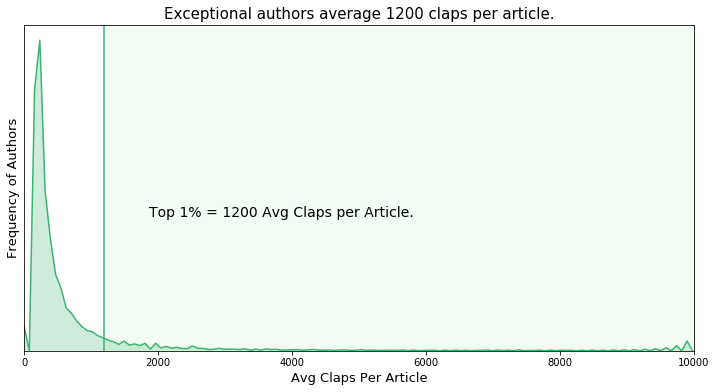

In [26]:
plot_frequency(CA.CA_Ratio,
              clip=[0,10000],
               bw=0.4,
              yvariable = "Authors",
               xvariable="Avg Claps per Article",
              title="Exceptional authors average 1200 claps per article.",
              shorten=False)

plt.show()

### Top 10 Most Clapped Authors (One-Hit-Wonders)
Notice that a majority of the top average clapped authors are <b>authors who have written 1 or 2 posts that have done EXTREMELY well.</b>

In [27]:
print("Top 10 Authors with Highest Claps per Article")
print()
print("Claps/Art  Total_Articles        Author                  URL")

rank=0
for auth in CA[:10].index:
    link = medium[medium.Author==auth].Author_url.values[0]
    link = link.split("?")[0]
    print(int(CA["CA_Ratio"][rank]),"        ",int(CA["count"][rank]),"          ",auth, "     ", link)
    rank+=1

Top 10 Authors with Highest Claps per Article

Claps/Art  Total_Articles        Author                  URL
172000          1            Jackson Cunningham       https://medium.com/@jacksoncunningham
102000          1            Scott Riddle       https://medium.com/@sgriddle
69000          1            Little Phil       https://medium.com/@littlephilcoin
67000          1            Daniel van Flymen       https://hackernoon.com/@vanflymen
58000          1            Mayukh Nair       https://medium.com/@nairmayukh
56000          1            Alex Birsan       https://medium.freecodecamp.org/@alex.birsan
54000          1            Katherine Fugate       https://medium.com/@katstory
52000          1            Kai Stinchcombe       https://medium.com/@kaistinchcombe
51354          3            Jason Li       https://medium.com/@ImJasonLi
51333          3            Ralph Ammer       https://medium.com/@ralphammer


### Top 10 Most Clapped Authors (with total articles > 29)
As we said before, only 1% of writers publish more than 29 articles. So here is the <b>leaderboard for most average clapped authors among prolific writers. </b>

In [28]:
veterans = CA[CA["count"]>29][:10]
print("Top 10 Veteran Authors with Highest Claps per Article")
print()
print("Claps/Art  Total_Articles        Author                  URL")

rank=0
for auth in veterans.index:
    link = medium[medium.Author==auth].Author_url.values[0]
    link = link.split("?")[0]
    print(int(veterans["CA_Ratio"][rank]),"        ",int(veterans["count"][rank]),"     ",auth, "     ", link)
    rank+=1

Top 10 Veteran Authors with Highest Claps per Article

Claps/Art  Total_Articles        Author                  URL
20850          105       Benjamin P. Hardy       https://medium.com/@benjaminhardy
9977          63       Aytekin Tank       https://medium.com/@aytekintank
9021          64       Zat Rana       https://medium.com/@ztrana
7809          36       Per Harald Borgen       https://medium.com/@perborgen
7702          79       Anthony Moore       https://medium.com/@anthony_moore
7620          50       Ryan Holiday       https://medium.com/@RyanHoliday
7496          77       John Gorman       https://psiloveyou.xyz/@thisisgorman
6934          109       Thomas Oppong       https://medium.com/@alltopstartups
6872          30       Indrek Lasn       https://medium.com/@wesharehoodies
6443          31       E Price       https://medium.com/@dr_eprice


## Has an author written an exceptional article? (A different metric)

Average claps per article measures consistency of author performance, but it definitely has its flaws. In the previous sections we looked at the 99th percentile of claps-received for all articles and determined that exceptional Medium articles received two thousand claps.

We also found that writing in different fields (tags) drastically changes the cutoff for an exceptional article. <b>Could writing an exceptional article be a good way to rank author performance?</b> We see here that <b> only 1.2% of all Medium writers have written an exceptional story. (2000 claps)</b>

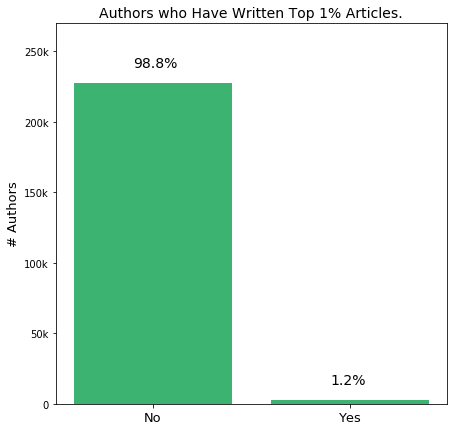

In [29]:
All_Authors = medium.Author.value_counts().shape[0] 
_99percentile = medium.Claps.quantile(q=0.99)

Authors_who_have = medium[medium.Claps>=_99percentile].Author.value_counts().shape[0]
Authors_who_have_not = All_Authors-Authors_who_have

x = [0, 1]
height= [Authors_who_have_not, Authors_who_have]

ylocs = [0,50000,100000,150000,200000,250000]
yticks = ["0","50k","100k","150k", "200k", "250k"]

plot_double(x, height,
            "No",
            "Yes",
            xlabel=None,
            ylabel="# Authors",
            ylocs=ylocs,
            yticks=yticks,
            ylim=270000,
            title="Authors who Have Written Top 1% Articles.")

This metric has its flaws as well. <b>Here we are solely baseing an author's performance by the highest popularity article they have ever achieved.</b> There is no way to tell if authors that have written an exceptional article have continued to do so consistently. Just how many exceptional articles are authors able to publish?

### How many exceptional articles are authors able to publish?

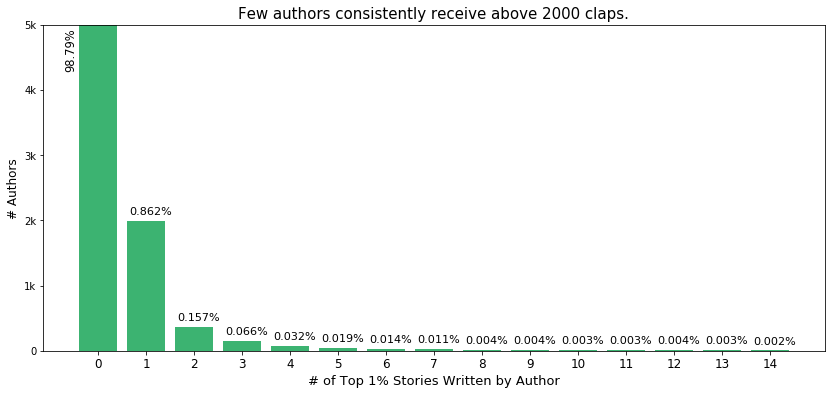

In [30]:
All_Authors = medium.Author.value_counts().shape[0] 
_99percentile = medium.Claps.quantile(q=0.99)

authors = medium[medium.Claps>=_99percentile].Author.value_counts()
height = [Authors_who_have_not]
x=[0]
for i in range(1,15):
    height.append(authors[authors==i].shape[0])
    x.append(i)
    
plt.figure(figsize=(14,6))
plt.bar(x, height, color = "mediumseagreen")

percent=0
for t, i in zip(height[1:], x[1:]):
    percent=t/All_Authors
    plt.text(i-.35, t+100, str(round(percent*100,3))+"%",fontsize=11.2)
plt.text(-0.7,4800, str(round(height[0]*100/All_Authors,2))+"%", rotation=90,fontsize=11.5)

plt.title("Few authors consistently receive above 2000 claps.", fontsize=15)
plt.ylim(0,5000)
plt.ylabel("# Authors",fontsize=12)
plt.yticks([0,1000,2000,3000,4000,5000], ["0","1k","2k", "3k", "4k", "5k"])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],fontsize=12)
plt.xlabel("# of Top 1% Stories Written by Author", fontsize=13)
plt.show()

Despite it's flaws this shows that <b>achieving the 99th percentile of article-claps is no small feet.</b> Authors who do manage to write an article receiveing 2000 claps should be proud, and make it their goal to consistently write exceptional articles.

### Some tags have fewer authors with exceptional articles.

It is interesting to note that <b>some of Medium's most popular tags (leadership, personal-development, life) have the fewest authors who have written an article in the 99th percentile of claps-received.</b> This makes sense as the cutoff for exceptional articles is significantly higher for these tags. 

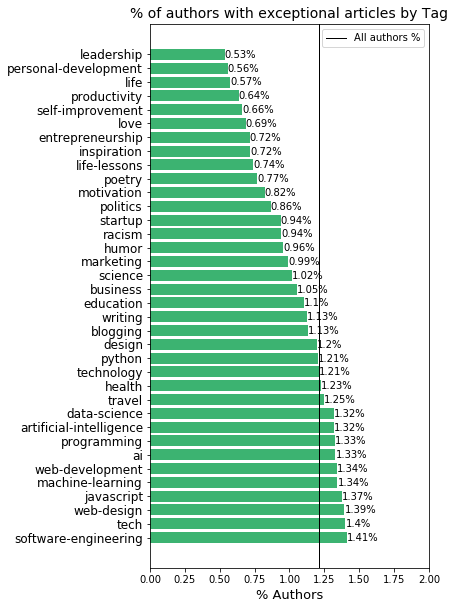

In [31]:
Authors_who_have = medium[medium.Claps>=_99percentile].Author.value_counts().shape[0]

all_authors = 0
pop_percent = (Authors_who_have)*100/All_Authors
tag_authors_who_have = []

for tag in tags:
    tag_df = medium[medium[tag]>0]
    all_tag_authors = (tag_df.Author.value_counts().shape[0])
    top_tag_authors = (tag_df[tag_df.Claps>tag_df.Claps.quantile(0.99)].Author.value_counts().shape[0])
    tag_authors_who_have.append(top_tag_authors*100 / all_tag_authors) 

tags_sort, tags_ninenine = sort_helper(tags, tag_authors_who_have)

temp=[]
for idx in range(len(tags_sort)):
    temp.append(tags_sort[idx][4:])
tags_sort = temp
    
plt.figure(figsize=(5,10))
plt.barh(tags_sort,tags_ninenine, color="mediumseagreen")
plt.axvline(pop_percent, color="black",lw=1,label="All authors %")

for idx in range(len(tags_ninenine)):
    plt.text(tags_ninenine[idx], idx-.25, str(round(tags_ninenine[idx],2))+"%")
    
plt.title("% of authors with exceptional articles by Tag", fontsize=14)
plt.legend()
plt.yticks(fontsize=12)
plt.xlabel("% Authors", fontsize=13)
plt.xlim(0,2)
plt.show()

<hr>
<h1 align="center">Analyzing Medium Publications</h1>

Publications are the best way for authors to drastically increase their reader-base. With this in mind, we will look at which publications are the most performant.

- Which publications have the most authors?
- Which publications have published the most articles?
- Which publications receives the most claps?
    - What is the 99th percentile for major publications?
    - Which publication averages the most claps per article?

<br>

## Which publications have the most authors?

In [32]:
publications = medium.Publication.value_counts()[:100].index
authors_in_pubs = []
for pub in publications:
    pub_df = medium[medium.Publication==pub]
    authors_in_pubs.append(pub_df.Author.value_counts().shape[0])

pubs_sort, authors_sort = sort_helper(publications, authors_in_pubs)

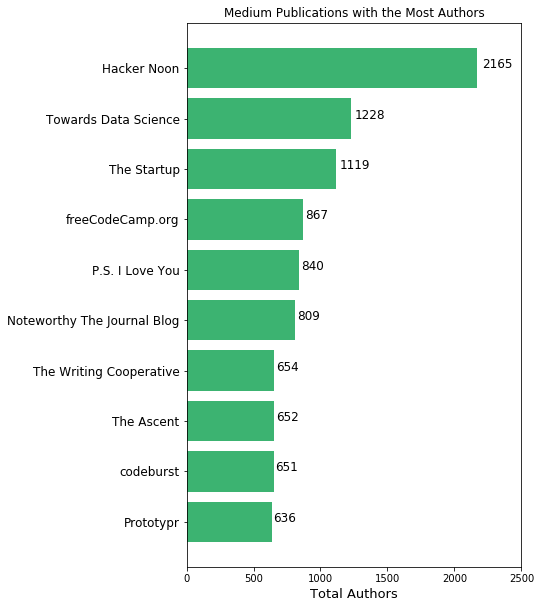

In [33]:
plt.figure(figsize=(6,10))
plt.barh(np.flip(pubs_sort[:10],axis=0), np.flip(authors_sort[:10],axis=0), color="mediumseagreen")

for idx in range(len(pubs_sort[:10])):
    value = np.flip(authors_sort[:10], axis=0)[idx]
    plt.text(value *1.02, idx, str(int(value)), fontsize=12)

plt.title("Medium Publications with the Most Authors")
plt.xlabel("Total Authors",fontsize=13)
plt.xlim(0,2500)
plt.yticks(fontsize=12)

plt.show()

## Which publications have published the most articles?

<b>Only 1% of publications have posted more than 63 articles.</b>

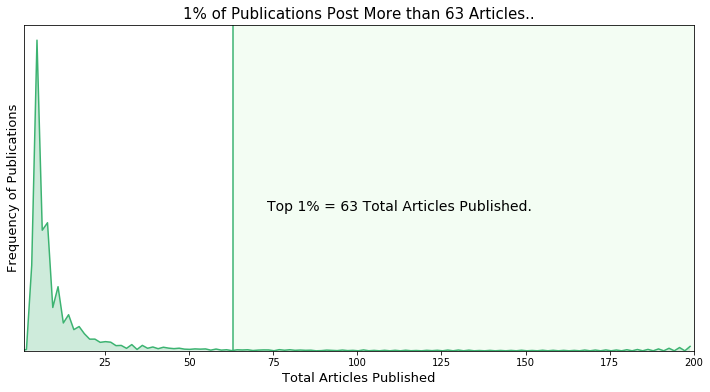

In [34]:
plot_frequency(medium.Publication.value_counts(),
              clip=[0,200],
              yvariable = "Publications",
               xvariable="Total Articles Published",
              title="1% of Publications Post More than 63 Articles..",
              shorten=False)

plt.show()

### Top 10 Publications with the most articles.

In [35]:
print("TOP 10 Most Publishing Publications")
print()
print("Publication             Articles")
print()
print(medium.Publication.value_counts()[:10])

TOP 10 Most Publishing Publications

Publication             Articles

Hacker Noon                5400
The Startup                4192
P.S. I Love You            3681
The Mission                3113
Towards Data Science       3062
Thrive Global              2419
The Ascent                 2386
The Writing Cooperative    2364
Poets Unlimited            2136
codeburst                  1838
Name: Publication, dtype: int64


## Which publications receive the most claps?

Below are the top 10 medium publications with the most <b>total  claps received.</b>

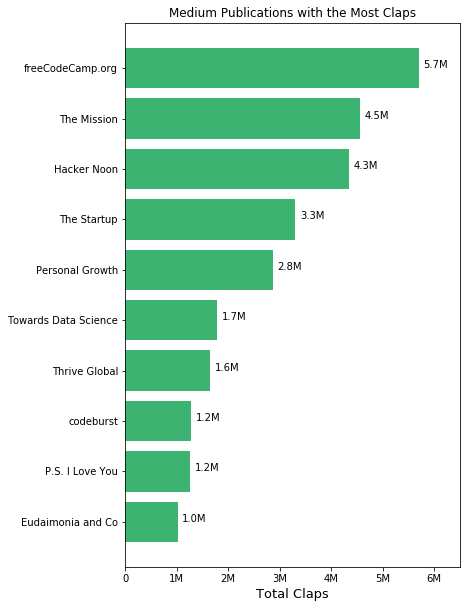

In [36]:
pubs  = medium.groupby("Publication").sum()
pubs = pubs.sort_values("Claps", ascending=True)
plt.figure(figsize=(6,10))
plt.barh(pubs.index[-10:], pubs.Claps[-10:], color="mediumseagreen")

for idx in [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]:
    plt.text(pubs.Claps[idx]+90000, 10+idx, str(pubs.Claps[idx])[0]+"."+str(pubs.Claps[idx])[1]+"M")


plt.title("Medium Publications with the Most Claps")
plt.xticks([0,1000000,2000000,3000000,4000000,5000000, 6000000], ["0","1M", "2M", "3M", "4M", "5M","6M"])
plt.xlabel("Total Claps",fontsize=13)
plt.xlim(0,6500000)
plt.show()


## What is the top 1% of articles in major publications? 

In [37]:
pubs = pubs_sort[:10]

#a list of ninety ninth percentiles for all tags.
pubs_ninenine=[]
for pub in pubs:
    ninenine = medium[medium.Publication==pub].Claps.quantile(q=0.99)
    pubs_ninenine.append(ninenine)

pubs_sort, pubs_ninenine = sort_helper(pubs,pubs_ninenine)

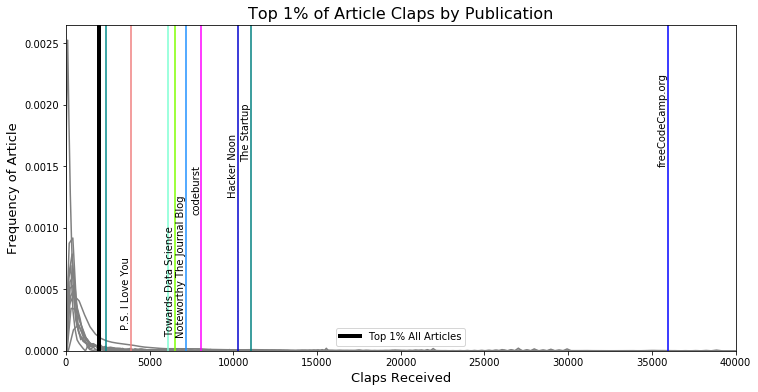

In [38]:
plt.figure(figsize=(12,6))
ax=plt.subplot()

#plotting the Clap Densities
for pub in pubs:
    sns.kdeplot(medium[medium.Publication==pub].Claps,
                color="grey",
                clip=[0,40000],
                label="",
                ax=ax,
                legend=False)
    
#plot the 99th percentiles
colorcount=0
vertical=0.0007
for idx in range(len(pubs_sort)):       
    if colorcount==14:
        colorcount=0
    if vertical>0.0025:
        vertical = 0.0006
        
    Color = colors[colorcount]  
    pub = pubs_sort[9-idx]
    plt.axvline(x=pubs_ninenine[9-idx], color=Color)
    colorcount+=1
    if idx in [0,1,3]:    
        continue
    plt.text(pubs_ninenine[9-idx]-600,vertical, pub, rotation=90)
    vertical+=0.00025

plt.axvline(x=2000, color="black",lw=4, label="Top 1% All Articles")

plt.title("Top 1% of Article Claps by Publication", fontsize=16)
plt.xlabel("Claps Received", fontsize=13)
#plt.yticks([])
plt.ylabel("Frequency of Article", fontsize=13)
plt.xlim(0,40000)
plt.legend()
plt.show()

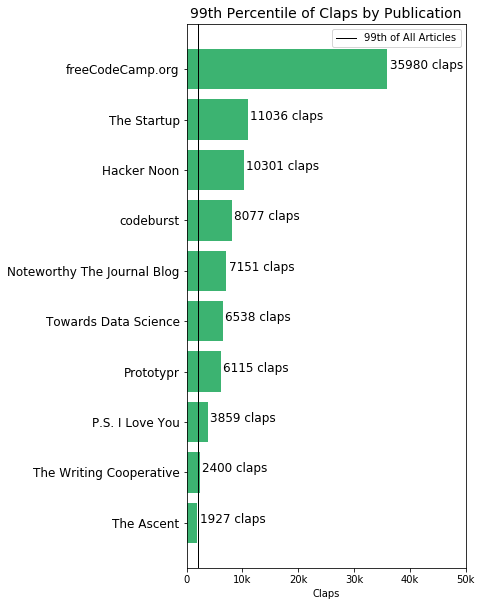

In [39]:
pubs_ninenine = np.flip(pubs_ninenine, axis=0)
pubs_sort = np.flip(pubs_sort, axis=0)


plt.figure(figsize=(5,10))
plt.barh(pubs_sort,pubs_ninenine, color="mediumseagreen")
plt.axvline(medium.Claps.quantile(0.99), color="black",lw=1,label="99th of All Articles")

for idx in range(len(pubs_ninenine)):
    plt.text(pubs_ninenine[idx]+400, idx, str(int(pubs_ninenine[idx]))+" claps", fontsize=12)

plt.title("99th Percentile of Claps by Publication", fontsize=14)
plt.legend()
plt.yticks(fontsize=12)
plt.xticks([0,10000,20000,30000,40000,50000],["0", "10k", "20k", "30k", "40k", "50k"])
plt.xlim(0,50000)
plt.xlabel("Claps")
plt.show()

## Which publications averaged the most claps?

In [40]:
temp = medium.copy()
temp["article_count"] = 1

temp = temp.dropna(subset=["Publication"])
pubs_arts = temp.groupby("Publication").sum()
pubs_arts["CA_Ratio"] = pubs_arts['Claps']/pubs_arts["article_count"]

pubs_arts = pubs_arts[pubs_arts["article_count"]>25]
pub_CA = pubs_arts.sort_values("CA_Ratio", ascending=False)[["CA_Ratio", "article_count"]]

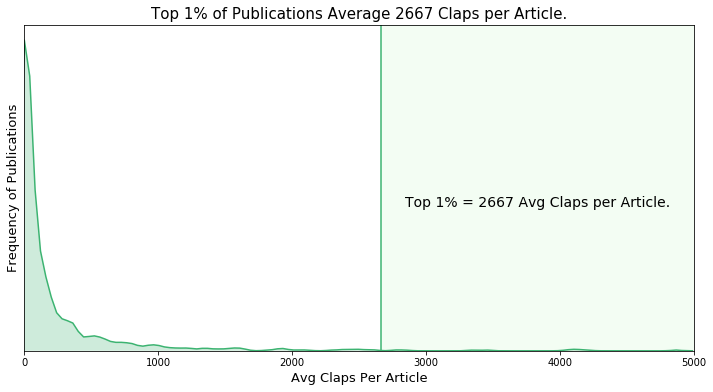

In [41]:
plot_frequency(pub_CA.CA_Ratio,
              clip=[0,5000],
              yvariable = "Publications",
               xvariable="Avg Claps per Article",
              title="Top 1% of Publications Average 2667 Claps per Article.",
              shorten=False)

plt.show()

### Top 10 Most Average Clapped Publications (No Restrictions)


In [42]:
pub_CA[:10]

,CA_Ratio,article_count
Publication,,
The Blog Of Darius Foroux,6013.452830,53
Personal Growth,4870.767402,589
Words for Life,4201.560976,41
SessionStack Blog,4130.961538,26
The Polymath Project,4110.648352,91
The Cooper Review,4057.653846,26
Eudaimonia and Co,3455.905085,295
freeCodeCamp.org,3350.015267,1703
webpack,2842.888889,27


### Top 10 Most Average Clapped Publications (Total Articles>63)
As we said before the average claps per article tends to inflate publications/authors who have posted fewer articles that have done exceptionally well. <b>Here we look at the publications who have posted more articles than any other publications. (The 99th percentile of articles published.)</b>


In [43]:
pub_CA[pub_CA["article_count"]>63][:10]

,CA_Ratio,article_count
Publication,,
Personal Growth,4870.767402,589
The Polymath Project,4110.648352,91
Eudaimonia and Co,3455.905085,295
freeCodeCamp.org,3350.015267,1703
The Westenberg Report,2774.066667,90
Signal v. Noise,2486.398374,123
ThinkGrowth.org,2107.535484,155
Better Humans,2038.686869,198
Design Sketch,1924.593407,91


<hr>
<h1 align="center">Mediums Most-Clapped Articles</h1>

## Top 10 Most Clapped Articles

In [44]:
rank=1
top_10 = medium.sort_values("Claps", ascending=False)[:10]["Title"]
top_10_urls = medium.sort_values("Claps", ascending=False)[:10]["url"]
top_10_claps = medium.sort_values("Claps", ascending=False)[:10]["Claps"]
top_10_auth = medium.sort_values("Claps", ascending=False)[:10]["Author"]


for title, url, clap, auth in zip(top_10, top_10_urls,top_10_claps, top_10_auth):
    url = url.split("?")[0]
    print(str(rank)+".  ", str(int(clap))+" claps","  ",title, "   by "+str(auth), "  \n", url)
    print()
    rank+=1

1.   215000 claps    Im harvesting credit card numbers and passwords from your site. Heres how.    by David Gilbertson   
 https://hackernoon.com/im-harvesting-credit-card-numbers-and-passwords-from-your-site-here-s-how-9a8cb347c5b5

2.   190000 claps    Travel Is No Cure for the Mind    by More To That   
 https://medium.com/personal-growth/travel-is-no-cure-for-the-mind-e449d3109d71

3.   172000 claps    Digital Exile: How I Got Banned for Life from AirBnB    by Jackson Cunningham   
 https://medium.com/@jacksoncunningham/digital-exile-how-i-got-banned-for-life-from-airbnb-615434c6eeba

4.   154000 claps    Laziness Does Not Exist    by E Price   
 https://medium.com/@dr_eprice/laziness-does-not-exist-3af27e312d01

5.   148000 claps    Our redesign of Mediums Clapsand why they may not have chosen to do it this way.    by Jason Li   
 https://medium.com/tomyum/our-redesign-of-mediums-claps-and-why-they-may-not-have-chosen-to-do-it-this-way-edc9ff6b586e

6.   147000 claps    The Rock T

## What is the range of claps in the top 1k?

In [45]:
top_1k = medium.sort_values("Claps", ascending=False)[:1000]

print("Min Claps: ",int(top_1k.Claps.min()), " Max Claps: ", int(top_1k.Claps.max()))

Min Claps:  10100  Max Claps:  215000


## How many authors are in the top 1000 articles in dataset?

In [46]:
print(top_1k.Author.value_counts().shape[0], "Authors")
print(round(top_1k.Author.value_counts().shape[0]*100/medium.Author.value_counts().shape[0],2), "% of all authors")

491 Authors
0.21 % of all authors


## What are the highest occuring publications, authors, Tags in the top 1k?

In [47]:
print("The Ten Most Frequent Authors in Top 1k:")
print()
print(top_1k.Author.value_counts()[:10])

The Ten Most Frequent Authors in Top 1k:

Benjamin P. Hardy    96
Kris Gage            38
Nicolas Cole         29
Thomas Oppong        22
Zat Rana             20
umair haque          18
Tim Denning          16
Anthony Moore        16
Darius Foroux        15
Aytekin Tank         14
Name: Author, dtype: int64


In [48]:
print("The Ten Most Frequent Publications in Top 1k:")
print()
print(top_1k.Publication.value_counts()[:10])

The Ten Most Frequent Publications in Top 1k:

freeCodeCamp.org             132
The Mission                   84
Thrive Global                 58
Hacker Noon                   56
Personal Growth               53
The Startup                   49
Eudaimonia and Co             17
Towards Data Science          15
codeburst                     13
The Blog Of Darius Foroux     13
Name: Publication, dtype: int64


In [49]:
print("The Ten Most Frequent Tags in Top 1k:")
print()
print(top_1k.sum()[6:].sort_values(ascending=False)[:10])

The Ten Most Frequent Tags in Top 1k:

Tag_productivity            172.0
Tag_programming             147.0
Tag_self-improvement        140.0
Tag_javascript              129.0
Tag_web-development         129.0
Tag_startup                 125.0
Tag_life-lessons            120.0
Tag_tech                    111.0
Tag_technology               98.0
Tag_personal-development     98.0
dtype: float64
